<center>
 <h1> INF395 - Introducción a las Redes Neuronales Artificiales</h1>
    <h2> Tarea 0</h2>
</center>
<b>Integrantes:</b>
* Camilo Saldías González - 201223512-K - camilo.saldias.12@sansano.usm.cl
* Felipe Vásquez Astudillo - 201473504-9 - felipe.vasquez.14@sansano.usm.cl

# Tabla de contenido
* [1.-Back-propagation (BP) from *Scratch*](#p1)
* [2.-Comparar back-propagation (BP) de Keras](#p2)
* [3.-Verificación numérica del gradiente para una componente](#p3)
* [4.-Implementar momentum como variante](#p4)

<div id='p1' />
## 1. Back-propagation (BP) from *Scratch*

Primero, se importan los paquetes relevantes.

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from timeit import default_timer as timer

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14.0, 12.0)
np.set_printoptions(suppress=True)

Variables de inicialización son definidas, para establecer el número de neuronas, dimension del input, del output y constantes de aprendizaje.

In [2]:
nn_input_dim = 4 # Dimensionalidad de capa de entrada
nn_output_dim = 3 # Dimensionalidad de capa de salida
nn_hidden1_dim = 32 #Dimensionalidad de capa 1
nn_hidden2_dim = 16 #Dimensionalidad de capa 2
epsilon = 0.01 # Tasa de aprendizaje de la red

Dado que hay que calcular el costo por cada iteración de la red neuronal, es necesario definir una función que reciba como parámetro el estado actual de la red.

In [3]:
def calculate_loss_cco(model, X, y, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax
    
    corect_logprobs = -1.0 * y * np.log(probs)
    data_loss = np.sum(corect_logprobs)
    return 1./X.shape[0] * data_loss

In [4]:
def calculate_loss_mse(model, X, y, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax
    
    corect_logprobs = np.square(y - probs)
    data_loss = np.sum(corect_logprobs)
    
    return 1./X.shape[0] * data_loss

Dado que el método SGD requiere que se trabaje con un orden aleatorio del set de entrenamiento, creamos una función que se encargue de entregar el set de entrenamiento en un orden aleatorio.

In [5]:
def shuffle_dataset(X, y):
    combined_dataset = np.concatenate((X_train, y_onehot), axis=1)
    np.random.shuffle(combined_dataset)
    x_shuffled, y_shuffled = np.hsplit(combined_dataset, [4])
    return (x_shuffled, y_shuffled)

La siguiente función también evalúa la red neuronal, pero en lugar de calcular el costo, obtiene los puntajes de clasificación y retorna las probabilidades asociadas.

In [6]:
def predict(model, X, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #Softmax
    return probs

Funciones de activación a utilizar son definidas, es decir la logística y ReLU, al igual que sus respectivas derivadas.

In [7]:
def ReLU(val):
    return np.maximum(0, val)
def BP_ReLU(val):
    return (val > 0).astype(int)

In [8]:
def Sigmoid(val):
    return 1.0 / (1.0 + np.exp(-1.0 * val))
def BP_Sigmoid(val):
    return (1 - Sigmoid(val)) * Sigmoid(val)

Por último, a continuación se presenta la rutina principal, que hace uso de las funciones anteriores e itera un número definido de veces.

In [9]:
# - num_epoch: Numero de ciclos (epochs) para entrenamiento de la red
# - print_loss: Logear los datos de error de clasificación y función de pérdida
# - loss_function: Seleccionar la función de pérdida a utilizar
#                  Categorical Cross-Entropy (cco) o Mean Squared Error (mse)
# - act_function: Seleccionar la función de activación a utilizar
#                 ReLU (relu) or Sigmoid (sigmoid)
def build_model(X, y, num_epoch=200, print_loss=False, loss_function = "cco", act_function = "relu"):
    
    # Inicializar los parámetros de la red a valores aleatorios.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden1_dim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden1_dim))
    W2 = np.random.randn(nn_hidden1_dim, nn_hidden2_dim) / np.sqrt(nn_hidden1_dim)
    b2 = np.zeros((1, nn_hidden2_dim))
    W3 = np.random.randn(nn_hidden2_dim, nn_output_dim) / np.sqrt(nn_hidden2_dim)
    b3 = np.zeros((1, nn_output_dim))

    # Esto es lo que retornaremos al final.
    model = {}
    it_data = []
    
    # Usamos SGD para el entrenamiento. Para cada epoch...
    for i in range(0, num_epoch):
        # Reordenamos aleatoriamente el dataset
        x_shuffled, y_shuffled = shuffle_dataset(X, y)
        
        epoch_loss = []
        correct_guesses = 0
        
        #...E iteramos sobre cada ejemplo, 1 a la vez
        for j in range(x_shuffled.shape[0]):
            x_example = x_shuffled[j].reshape((1,4)) #reshape() para que sea tratada como "matriz"
            y_example = y_shuffled[j]                #y no como un vector ((4,1) en lugar de (4,))
            
            # Feed-Forward
            in1 = x_example.dot(W1) + b1
            out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
            in2 = out1.dot(W2) + b2
            out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
            in3 = out2.dot(W3) + b3
            exp_scores = np.exp(in3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #Softmax

            # Back-Propagation
            delta4 = probs - y_example
            dW3 = np.dot(out2.T, delta4)
            db3 = np.sum(delta4, axis=0, keepdims=True)
            delta3 = delta4.dot(W3.T) * (BP_ReLU(out2) if act_function == 'relu' else BP_Sigmoid(out2)) #ReLU o Sigmoid
            dW2 = np.dot(out1.T, delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * (BP_ReLU(out1) if act_function == 'relu' else BP_Sigmoid(out1)) #ReLU o Sigmoid
            dW1 = np.dot(x_example.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Asignamos los parámetros del modelo hasta el momento, antes de aplicar SGD
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

            #Cálculo del error (CCO or MSE)
            loss = calculate_loss_cco(model, x_example, y_example, act_function) if loss_function == 'cco' else calculate_loss_mse(model, x_example, y_example, act_function)
            epoch_loss.append(loss)
            
            #Error de clasificación (): número de predicciones correctas / número de ejemplos
            if np.argmax(probs) == np.argmax(y_example): correct_guesses += 1
                        
            #Actualizamos los parámetros de nuestra red
            W1 += -epsilon * dW1 * loss
            b1 += -epsilon * db1 * loss
            W2 += -epsilon * dW2 * loss
            b2 += -epsilon * db2 * loss
            W3 += -epsilon * dW3 * loss
            b3 += -epsilon * db3 * loss

            # Asignamos los parámetros del modelo luego de ser actualizados
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        
        # Opcionalmente, logeamos error (loss) y error de clasificación (accuracy)
        if print_loss:
            total_loss = np.average(epoch_loss)
            total_accuracy = correct_guesses / x_shuffled.shape[0]
            it_data.append( (i, total_loss, total_accuracy) )
    gradient={"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2,"dW3":dW3,"db3":db3}    
    return (model, it_data, gradient)

De la librería **sklearn** se obtiene el set de datos a evaluar.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#transform target to one hot vector
import keras
y_onehot = keras.utils.to_categorical(y_train)
num_examples = len(X_train)

/Users/camilo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Con las funciones anteriores, se procede a generar el modelo de la red neuronal y luego se evalúa el set de datos para un número determinado de iteraciones.

Este proceso es ilustrado en un gráfico de pérdida en función de las iteraciones, para cada una de las posibles combinaciones de función de error / función de activación.

Tiempo de ejecución para CCO/ReLU: 2.756475549998868 seg
Tiempo de ejecución para CCO/Sigmoid: 3.2489638189981633 seg
Tiempo de ejecución para MSE/ReLU: 2.7717312120003044 seg
Tiempo de ejecución para MSE/Sigmoid: 3.1820326969973394 seg


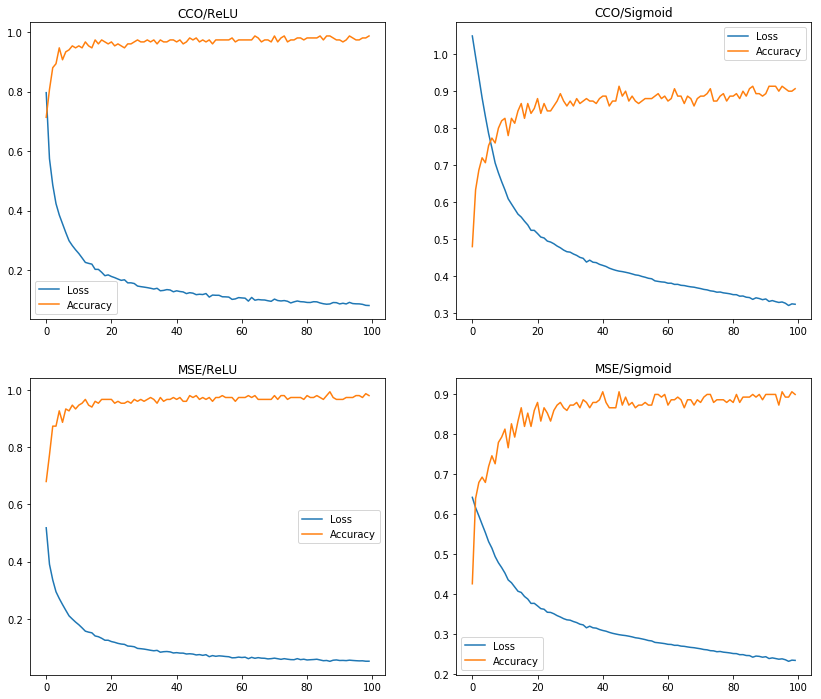

In [11]:
# Modelo 1: CCO / ReLU
start = timer()
model_1, iteration_data_1,grad_1 = build_model(X_train, y_onehot.astype(int), 100, True, "cco", "relu")
end = timer()
epoch_1, loss_1, accuracy_1 = zip(*iteration_data_1)
print("Tiempo de ejecución para CCO/ReLU: {} seg".format(end - start))

#Modelo 2: CCO / Sigmoid
start = timer()
model_2, iteration_data_2,grad_2 = build_model(X_train, y_onehot.astype(int), 100, True, "cco", "sigmoid")
end = timer()
epoch_2, loss_2, accuracy_2 = zip(*iteration_data_2)
print("Tiempo de ejecución para CCO/Sigmoid: {} seg".format(end - start))

#Modelo 3: MSE / ReLU
start = timer()
model_3, iteration_data_3,grad_3 = build_model(X_train, y_onehot.astype(int), 100, True, "mse", "relu")
end = timer()
epoch_3, loss_3, accuracy_3 = zip(*iteration_data_3)
print("Tiempo de ejecución para MSE/ReLU: {} seg".format(end - start))

#Modelo 2: MSE / Sigmoid
start = timer()
model_4, iteration_data_4,grad_4 = build_model(X_train, y_onehot.astype(int), 100, True, "mse", "sigmoid")
end = timer()
epoch_4, loss_4, accuracy_4 = zip(*iteration_data_4)
print("Tiempo de ejecución para MSE/Sigmoid: {} seg".format(end - start))

plt.subplot(221)
linea1,=plt.plot(epoch_1, loss_1, label="Loss")
linea2,=plt.plot(epoch_1, accuracy_1, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('CCO/ReLU')
plt.subplot(222)
linea1,=plt.plot(epoch_2, loss_2, label="Loss")
linea2,=plt.plot(epoch_2, accuracy_2, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('CCO/Sigmoid')
plt.subplot(223)
linea1,=plt.plot(epoch_3, loss_3, label="Loss")
linea2,=plt.plot(epoch_3, accuracy_3, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('MSE/ReLU')
plt.subplot(224)
linea1,=plt.plot(epoch_4, loss_4, label="Loss")
linea2,=plt.plot(epoch_4, accuracy_4, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('MSE/Sigmoid')
plt.show()

Se puede observar que aquellos modelos que utilizaron como función de activación ReLU, convergen más rápido a valores pequeños de costo, presentando además una precisión mayor durante compilación.

También es apreciable, aunque en menor medida, que el uso de _Mean Squared Error_ como métrica de costo afecta favorablemente en la convergencia de costo y en la precisión del modelo.

Finalmente, notar que los modelos utilizando función Sigmoide suelen tardar más en computar que los que utilizaron ReLU. Esto se puede explicar en la implementación de ambas funciones, Sigmoide requiriendo varias operaciones matemáticas y ReLU solo un llamado sencillo a otra función.

$$S(z)=\frac{1}{1+e^{-x}}$$

$$ReLU(z)=max(0,z)$$

A modo de ilustración, se comparan ambas funciones individualmente para 1000 iteraciones.

In [12]:
start = timer()
for i in range(1000):
    Sigmoid(-4)
end = timer()
print("Tiempo de ejecución para Sigmoide: {} seg".format(end - start))

start = timer()
for i in range(1000):
    ReLU(-4)
end = timer()
print("Tiempo de ejecución para ReLU: {} seg".format(end - start))


Tiempo de ejecución para Sigmoide: 0.003768410999327898 seg
Tiempo de ejecución para ReLU: 0.00284406900027534 seg


Finalmente, para la configuración CCO/ReLU, creamos la matriz de confusión utilizando la librería *sklearn*:

In [13]:
y_predicted = predict(model_1, X_train, "relu")
sklearn.metrics.confusion_matrix(y_train, np.argmax(y_predicted, axis=1))

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]])

La matriz de confusión es una representación simple para identificar la categorización incorrecta de clases hecha por el modelo. Esta contiene todas las predicciones hechas, donde las columnas corresponden a la categorización hecha por el modelo y las filas la categorización correcta.

De la definición anterior se entiende que los valores de la diagonal son elementos correctamente clasificados, mientras que cualquier otro indica una identificación errónea de un elemento.

<div id='p2' />
## 2.- Comparar back-propagation (BP) de Keras

Se procede a generar el modelo utilizando los pasos indicados por el enunciado. Primero las librerías de keras son importadas.

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

Modelos para cada combinación de funciones de activación y de costo son generados, utilizando el mismo orden que en la pregunta anterior.

In [15]:
model1 = Sequential()
model1.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
model1.add(Dense(16, activation="relu"))
model1.add(Dense(3, activation="softmax"))
model1.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])
model2 = Sequential()
model2.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
model2.add(Dense(16, activation="sigmoid"))
model2.add(Dense(3, activation="softmax"))
model2.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])
model3 = Sequential()
model3.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
model3.add(Dense(16, activation="relu"))
model3.add(Dense(3, activation="softmax"))
model3.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])
model4 = Sequential()
model4.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
model4.add(Dense(16, activation="sigmoid"))
model4.add(Dense(3, activation="softmax"))
model4.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

Entonces se entrenan los modelos, guardando la información de las iteraciones.

In [16]:
start = timer()
history1=model1.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
end = timer()
print("Tiempo de ejecución para CCO/ReLU: {} seg".format(end - start))
start = timer()
history2=model2.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
end = timer()
print("Tiempo de ejecución para CCO/Sigmoid: {} seg".format(end - start))
start = timer()
history3=model3.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
end = timer()
print("Tiempo de ejecución para MSE/ReLU: {} seg".format(end - start))
start = timer()
history4=model4.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)
end = timer()
print("Tiempo de ejecución para MSE/Sigmoid: {} seg".format(end - start))

Tiempo de ejecución para CCO/ReLU: 38.44192020600167 seg
Tiempo de ejecución para CCO/Sigmoid: 41.92391382599817 seg
Tiempo de ejecución para MSE/ReLU: 41.4723938979987 seg
Tiempo de ejecución para MSE/Sigmoid: 36.702988188000745 seg


Es inmediatamente perceptible la diferencia de tiempo, si bien varía de computador a computador la velocidad de ejecución, los modelos de Keras tienden a tomar en todos los casos más que los anteriores.

Luego son graficados cada par de modelos correspondientes, los compilados en la primera pregunta y los recién generados.

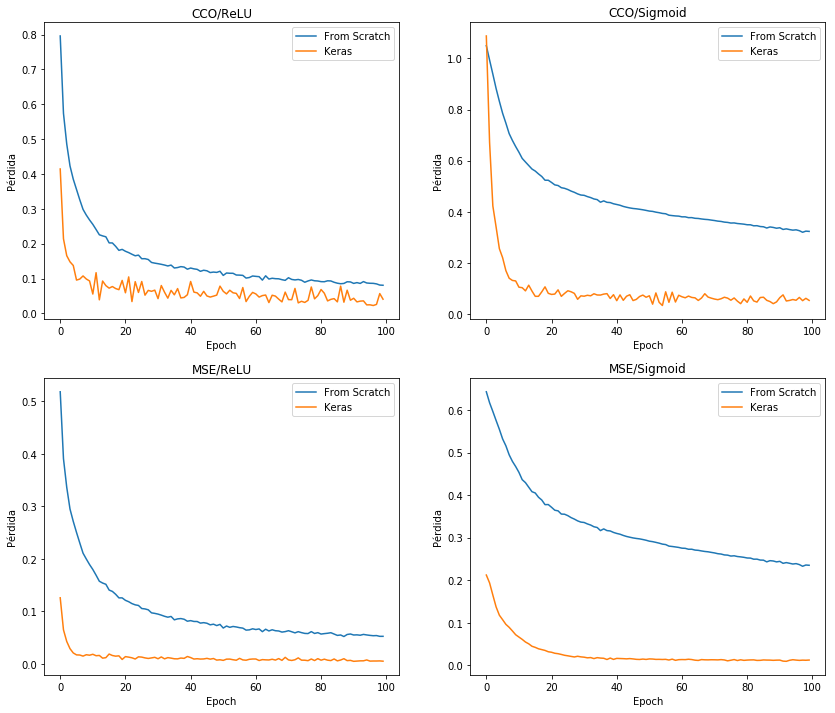

In [17]:
plt.subplot(221)
linea1,=plt.plot(epoch_1, loss_1, label="From Scratch")
linea2,=plt.plot(epoch_1, history1.history["loss"], label="Keras")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('CCO/ReLU')
plt.legend(handles=[linea1,linea2])
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.subplot(222)
linea1,=plt.plot(epoch_2, loss_2, label="From Scratch")
linea2,=plt.plot(epoch_2, history2.history["loss"], label="Keras")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('CCO/Sigmoid')
plt.legend(handles=[linea1,linea2])
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.subplot(223)
linea1,=plt.plot(epoch_3, loss_3, label="From Scratch")
linea2,=plt.plot(epoch_3, history3.history["loss"], label="Keras")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.gca().set_title('MSE/ReLU')
plt.legend(handles=[linea1,linea2])
plt.subplot(224)
linea1,=plt.plot(epoch_4, loss_4, label="From Scratch")
linea2,=plt.plot(epoch_4, history4.history["loss"], label="Keras")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('MSE/Sigmoid')
plt.legend(handles=[linea1,linea2])
plt.xlabel("Epoch")
plt.ylabel("Pérdida")
plt.show()

Se puede evidenciar que el modelo generado por Keras converge con mayor rapidez en todos los casos. Notablemente, los modelos de Keras que utilizan _Categorical Cross-Entropy_ aparentan ser menos estables en términos de pérdida, sin embargo siguen teniendo mejor desempeño que los compilados anteriormente.

Además, las líneas descritas por Keras reflejan el comportamiento observado en la pregunta 1, con ReLU y MSE presentando la convergencia más rápida, en contraste con función sigmoide y CCO.

<div id='p3' />
# 3.- Verificación numérica del gradiente para una componente

El valor para un peso entre la primera y segunda capa buscado es: 
$$\frac{ \partial Loss}{\partial w^1}$$ 

Este es calculado en el paso de backpropagation, denotado por la llave _dW1_ en las variables *grad_1* y *grad_3*, conteniendo la gradiente del modelo _"CCO/ReLU"_ y _"MSE/ReLU"_ respectivamente.

Primero se geneneran dos números aleatorios, el primero correspondiente a la neurona de la capa de entrada, y el segundo a la neurona del primer nivel escondido. 

In [18]:
inputRand1=np.random.randint(4)
pesoRand1=np.random.randint(32)
inputRand2=np.random.randint(4)
pesoRand2=np.random.randint(32)

Notar que como el peso puede ser 0, y dado que para comparar magnitudes se utilizará una división, el peso debe ser vuelto a seleccionar para evitar indefiniciones.

In [19]:
dW1_1=grad_1["dW1"][inputRand1][pesoRand1]
if(dW1_1==0.0):
    while(True):
        pesoRand1=np.random.randint(32)
        dW1_1=grad_1["dW1"][inputRand1][pesoRand1]
        if(dW1_1!=0.0):
            break
dW1_3=grad_3["dW1"][inputRand2][pesoRand2]
if(dW1_3==0.0):
    while(True):
        pesoRand2=np.random.randint(32)
        dW1_3=grad_3["dW1"][inputRand2][pesoRand2]
        if(dW1_3!=0.0):
            break
print(dW1_1,dW1_3)

-0.00590257788512099 -0.0073407149082461215


Luego un valor para $\epsilon$ es elegido.

In [20]:
epsilon=10**-10

Se guarda en una nueva variable los pesos de cada modelo con $\epsilon$ agregado en la dirección $w^1_{ij}$.

In [21]:
tW1=np.copy(model_1["W1"])
tW1[inputRand1][pesoRand1]=tW1[inputRand1][pesoRand1]+epsilon
tW3=np.copy(model_3["W1"])
tW3[inputRand2][pesoRand2]=tW3[inputRand2][pesoRand2]+epsilon

In [22]:
modelo_prima_1={ 'W1': tW1, 'b1': model_1["b1"], 'W2': model_1["W2"], 'b2': model_1["b2"], 'W3': model_1["W3"], 'b3': model_1["b3"]}
modelo_prima_3={ 'W1': tW3, 'b1': model_3["b1"], 'W2': model_3["W2"], 'b2': model_3["b2"], 'W3': model_3["W3"], 'b3': model_3["b3"]}

Finalmente se vuelve a computar con la función de costo correspondiente (*calculate_loss_cco()* para el primer modelo y *calculate_loss_mse()* para el tercero) con la definición de derivada.

In [23]:
dW1_def1=(calculate_loss_cco(modelo_prima_1,X_train, y_onehot.astype(int),act_function="relu")-calculate_loss_cco(model_1,X_train, y_onehot.astype(int),act_function="relu"))/epsilon
dW1_def3=(calculate_loss_mse(modelo_prima_3,X_train, y_onehot.astype(int),act_function="relu")-calculate_loss_mse(model_3,X_train, y_onehot.astype(int),act_function="relu"))/epsilon

A continuación se presentan ambos valores del modelo *CCO/ReLU*, el calculado durante entrenamiento y por definición.

In [24]:
print("dW1: "+str(dW1_1))
print("Definición: "+str(dW1_def1))
print("Diferencia de magnitud: "+str(abs(dW1_def1/dW1_1)))

dW1: -0.00590257788512099
Definición: 0.0021035950759085154
Diferencia de magnitud: 0.3563858227455471


La misma comparación es hecha para el modelo *MSE/ReLU*.

In [25]:
print("dW1: "+str(dW1_3))
print("Definición: "+str(dW1_def3))
print("Diferencia de magnitud: "+str(abs(dW1_def3/dW1_3)))

dW1: -0.0073407149082461215
Definición: -0.0020299734115880597
Diferencia de magnitud: 0.27653620075991625


Como se puede apreciar, los valores se distancian con una magnitud mucho menor a $10^6$, lo cuál es aceptable bajo las restricciones del enunciado. Con esto se comprueba de que la derivada calculada en durante _backward pass_ fue calculada correctamente.

Esto vuelve se replicar dos veces más.

In [26]:
inputRand1=np.random.randint(4)
pesoRand1=np.random.randint(32)
inputRand2=np.random.randint(4)
pesoRand2=np.random.randint(32)
dW1_1=grad_1["dW1"][inputRand1][pesoRand1]
if(dW1_1==0.0):
    while(True):
        pesoRand1=np.random.randint(32)
        dW1_1=grad_1["dW1"][inputRand1][pesoRand1]
        if(dW1_1!=0.0):
            break
dW1_2=grad_1["dW1"][inputRand2][pesoRand2]
if(dW1_2==0.0):
    while(True):
        pesoRand2=np.random.randint(32)
        dW1_2=grad_1["dW1"][inputRand2][pesoRand2]
        if(dW1_2!=0.0):
            break
tW1=np.copy(model_1["W1"])
tW1[inputRand1][pesoRand1]=tW1[inputRand1][pesoRand1]+epsilon
tW2=np.copy(model_1["W1"])
tW2[inputRand2][pesoRand2]=tW2[inputRand2][pesoRand2]+epsilon
modelo_prima_1={ 'W1': tW1, 'b1': model_1["b1"], 'W2': model_1["W2"], 'b2': model_1["b2"], 'W3': model_1["W3"], 'b3': model_1["b3"]}
modelo_prima_2={ 'W1': tW2, 'b1': model_1["b1"], 'W2': model_1["W2"], 'b2': model_1["b2"], 'W3': model_1["W3"], 'b3': model_1["b3"]}
dW1_def1=(calculate_loss_cco(modelo_prima_1,X_train, y_onehot.astype(int),act_function="relu")-calculate_loss_cco(model_1,X_train, y_onehot.astype(int),act_function="relu"))/epsilon
dW1_def2=(calculate_loss_cco(modelo_prima_2,X_train, y_onehot.astype(int),act_function="relu")-calculate_loss_cco(model_1,X_train, y_onehot.astype(int),act_function="relu"))/epsilon

In [27]:
print("dW1: "+str(dW1_1))
print("Definición: "+str(dW1_def1))
print("Diferencia de magnitud: "+str(abs(dW1_def1/dW1_1)))
print("\n")
print("dW1: "+str(dW1_2))
print("Definición: "+str(dW1_def2))
print("Diferencia de magnitud: "+str(abs(dW1_def2/dW1_2)))

dW1: 0.01429962808683825
Definición: -0.0032843172625973693
Diferencia de magnitud: 0.2296785093047518


dW1: 0.004386411478597839
Definición: 0.0020200507933054723
Diferencia de magnitud: 0.460524691575721


Ambos valores calculados muestran una diferencia de magnitud menor respecto a las derivadas resultantes del entrenamiento, sin embargo sigue siendo aparente. Parte de esto puede deberse a la cantidad de operaciones asociadas para calcular el costo del modelo, produciendo pérdida de información que de otro modo no ocurriría.

<div id='p4' />
# 4.- Implementar momentum como variante

Para entrenar nuestra red neuronal creada en la primera pregunta utilizando momentum clásico, modificamos la función *build_model*:

In [28]:
# - num_epoch: Numero de ciclos (epochs) para entrenamiento de la red
# - print_loss: Logear los datos de error de clasificación y función de pérdida
# - loss_function: Seleccionar la función de pérdida a utilizar
#                  Categorical Cross-Entropy (cco) o Mean Squared Error (mse)
# - act_function: Seleccionar la función de activación a utilizar
#                 ReLU (relu) or Sigmoid (sigmoid)
def build_model_momentum(X, y, num_epoch=200, print_loss=False, loss_function = "cco", act_function = "relu"):
    # Inicializar los parámetros de la red a valores aleatorios.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden1_dim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden1_dim))
    W2 = np.random.randn(nn_hidden1_dim, nn_hidden2_dim) / np.sqrt(nn_hidden1_dim)
    b2 = np.zeros((1, nn_hidden2_dim))
    W3 = np.random.randn(nn_hidden2_dim, nn_output_dim) / np.sqrt(nn_hidden2_dim)
    b3 = np.zeros((1, nn_output_dim))

    # Esto es lo que retornaremos al final.
    model = {}
    it_data = []
    
    #Momentum clásico: mantenemos los deltas de la iteración anterior
    prev_delta = { 'W1': 0, 'b1': 0, 'W2': 0, 'b2': 0, 'W3': 0, 'b3': 0}
    
    # Usamos SGD para el entrenamiento. Para cada epoch...
    for i in range(0, num_epoch):
        # Reordenamos aleatoriamente el dataset
        x_shuffled, y_shuffled = shuffle_dataset(X, y)
        
        epoch_loss = []
        correct_guesses = 0
        
        #...E iteramos sobre cada ejemplo, 1 a la vez
        for j in range(x_shuffled.shape[0]):
            x_example = x_shuffled[j].reshape((1,4)) #reshape() para que sea tratada como "matriz"
            y_example = y_shuffled[j]                #y no como un vector ((4,1) en lugar de (4,))
            
            # Feed-Forward
            in1 = x_example.dot(W1) + b1
            out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
            in2 = out1.dot(W2) + b2
            out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
            in3 = out2.dot(W3) + b3
            exp_scores = np.exp(in3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #Softmax

            # Back-Propagation
            delta4 = probs - y_example
            dW3 = np.dot(out2.T, delta4)
            db3 = np.sum(delta4, axis=0, keepdims=True)
            delta3 = delta4.dot(W3.T) * (BP_ReLU(out2) if act_function == 'relu' else BP_Sigmoid(out2)) #ReLU o Sigmoid
            dW2 = np.dot(out1.T, delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * (BP_ReLU(out1) if act_function == 'relu' else BP_Sigmoid(out1)) #ReLU o Sigmoid
            dW1 = np.dot(x_example.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Asignamos los parámetros del modelo hasta el momento, antes de aplicar SGD
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

            #Cálculo del error (CCO or MSE)
            loss = calculate_loss_cco(model, x_example, y_example, act_function) if loss_function == 'cco' else calculate_loss_mse(model, x_example, y_example, act_function)
            epoch_loss.append(loss)
            
            #Error de clasificación (): número de predicciones correctas / número de ejemplos
            if np.argmax(probs) == np.argmax(y_example): correct_guesses += 1
                        
            #Actualizamos los parámetros de nuestra red
            delta_W1 = -epsilon * dW1 * loss
            delta_b1 = -epsilon * db1 * loss
            delta_W2 = -epsilon * dW2 * loss
            delta_b2 = -epsilon * db2 * loss
            delta_W3 = -epsilon * dW3 * loss
            delta_b3 = -epsilon * db3 * loss
            
            W1 += delta_W1
            b1 += delta_b1
            W2 += delta_W2
            b2 += delta_b2
            W3 += delta_W3
            b3 += delta_b3
            
            W1 += momentum * prev_delta['W1']
            b1 += momentum * prev_delta['b1']
            W2 += momentum * prev_delta['W2']
            b2 += momentum * prev_delta['b2']
            W3 += momentum * prev_delta['W3']
            b3 += momentum * prev_delta['b3']

            # Asignamos los parámetros del modelo luego de ser actualizados
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
            #Momentum clásico: Actualizamos los deltas (los deltas de ahora serán los deltas previos de la prox iterac)
            prev_delta = { 'W1': delta_W1, 'b1': delta_b1, 'W2': delta_W2, 'b2': delta_b2, 'W3': delta_W3, 'b3': delta_b3}
        
        # Opcionalmente, logeamos error (loss) y error de clasificación (accuracy)
        if print_loss:
            total_loss = np.average(epoch_loss)
            total_accuracy = correct_guesses / x_shuffled.shape[0]
            it_data.append( (i, total_loss, total_accuracy) )
    gradient={"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2,"dW3":dW3,"db3":db3}    
    return (model, it_data, gradient)

Ahora, analicemos el desempeño de esta modificación realizando los mismos gráficos que realizamos en la primera pregunta, con la adición de la definición de un momentum.

In [29]:
momentum = 0.7

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#transform target to one hot vector
import keras
y_onehot = keras.utils.to_categorical(y_train)
num_examples = len(X_train)

nn_input_dim = 4 # Dimensionalidad de capa de entrada
nn_output_dim = 3 # Dimensionalidad de capa de salida
nn_hidden1_dim = 32 #Dimensionalidad de capa 1
nn_hidden2_dim = 16 #Dimensionalidad de capa 2
epsilon = 0.01 # Tasa de aprendizaje de la red

Tiempo de ejecución para CCO/ReLU: 5.8181994010010385 seg
Tiempo de ejecución para CCO/Sigmoid: 4.9547224909983925 seg
Tiempo de ejecución para MSE/ReLU: 3.8500720180018106 seg
Tiempo de ejecución para MSE/Sigmoid: 4.092592656998022 seg


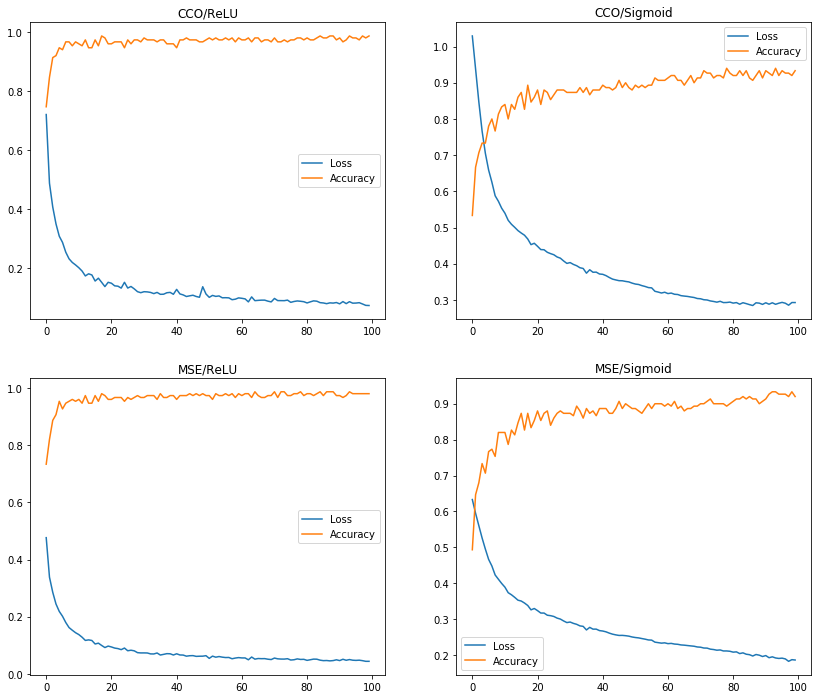

In [31]:
# Modelo 1: CCO / ReLU
start = timer()
model_1, iteration_data_1,grad_1 = build_model_momentum(X_train, y_onehot.astype(int), 100, True, "cco", "relu")
end = timer()
epoch_1, loss_1, accuracy_1 = zip(*iteration_data_1)
print("Tiempo de ejecución para CCO/ReLU: {} seg".format(end - start))

#Modelo 2: CCO / Sigmoid
start = timer()
model_2, iteration_data_2,grad_2 = build_model_momentum(X_train, y_onehot.astype(int), 100, True, "cco", "sigmoid")
end = timer()
epoch_2, loss_2, accuracy_2 = zip(*iteration_data_2)
print("Tiempo de ejecución para CCO/Sigmoid: {} seg".format(end - start))

#Modelo 3: MSE / ReLU
start = timer()
model_3, iteration_data_3,grad_3 = build_model_momentum(X_train, y_onehot.astype(int), 100, True, "mse", "relu")
end = timer()
epoch_3, loss_3, accuracy_3 = zip(*iteration_data_3)
print("Tiempo de ejecución para MSE/ReLU: {} seg".format(end - start))

#Modelo 2: MSE / Sigmoid
start = timer()
model_4, iteration_data_4,grad_4 = build_model_momentum(X_train, y_onehot.astype(int), 100, True, "mse", "sigmoid")
end = timer()
epoch_4, loss_4, accuracy_4 = zip(*iteration_data_4)
print("Tiempo de ejecución para MSE/Sigmoid: {} seg".format(end - start))

plt.subplot(221)
linea1,=plt.plot(epoch_1, loss_1, label="Loss")
linea2,=plt.plot(epoch_1, accuracy_1, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('CCO/ReLU')
plt.subplot(222)
linea1,=plt.plot(epoch_2, loss_2, label="Loss")
linea2,=plt.plot(epoch_2, accuracy_2, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('CCO/Sigmoid')
plt.subplot(223)
linea1,=plt.plot(epoch_3, loss_3, label="Loss")
linea2,=plt.plot(epoch_3, accuracy_3, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('MSE/ReLU')
plt.subplot(224)
linea1,=plt.plot(epoch_4, loss_4, label="Loss")
linea2,=plt.plot(epoch_4, accuracy_4, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=[linea1,linea2])
plt.gca().set_title('MSE/Sigmoid')
plt.show()

Se puede apreciar que, a simple vista, los 4 métodos convergen más rápido de lo que convergían utilizando SGD por sí sola. Por lo tanto, dependiendo del valor escogido del momentum (más acerca de eso en un momento), la mejora puede ser bastante significativa. Ahora, dado que el momentum es un valor libre, tomará ensayo y error la elección de un valor adecuado.

En esencia, durante las primeras etapas del entrenamiento, momentum nos permite movernos mucho más rápido que con el método anterior. Luego, cuando estamos más cerca de la convergencia, el delta es menor y, en consecuencia, el momentum es menor; de esa manera es menos probable "saltarnos" el mínimo global de la función objetivo. En otras palabras, el momentum clásico nos permite contar con una tasa de aprendizaje adaptativa, que varía en función de los parámetros de la red.